<a href="https://colab.research.google.com/github/HiroshiATakano/GitHub/blob/master/3_7_%E6%AD%A3%E8%A6%8F%E7%B7%9A%E5%BD%A2%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%matplotlib inline

import pickle
import statsmodels.formula.api as smf
import pystan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib import colors as mcolors
from pystan import StanModel
import pickle

import seaborn as sns
import sys
import math
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from scipy.stats import norm

from statsmodels.formula.api import glm
import statsmodels.api as sm


import os

path = os.getcwd()

try:
    os.chdir(path + "/drive/My Drive/RとStanで始めるベイズ統計モデリングによるデータ分析入門")
except:
    pass

os.getcwd()

'/content/drive/My Drive/RとStanで始めるベイズ統計モデリングによるデータ分析入門'

In [4]:
sales_climate = pd.read_csv("input/3-7-1-beer-sales-4.csv")
sales_climate.head()

,sales,weather,temperature
0,40.643344,cloudy,13.7
1,99.552683,cloudy,24.0
2,85.326847,cloudy,21.5
3,69.287884,cloudy,13.4
4,71.099425,cloudy,28.9


In [0]:
sales_climate_2 = pd.get_dummies(sales_climate,drop_first=True)

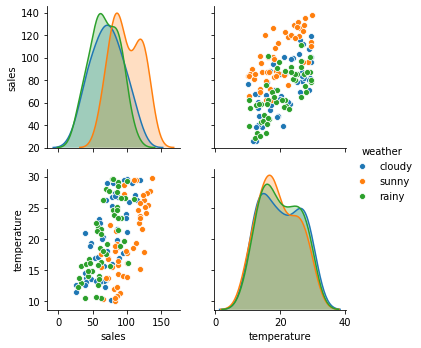

In [6]:
sns.pairplot(sales_climate,hue="weather")

In [7]:
with open("model/3-4-1-lm-design-matrix.stan") as f:
    print(f.read())

data { 
  int N;                // サンプルサイズ
  int K;                // デザイン行列の列数(説明変数の数＋１)
  vector[N] Y;          // 応答変数 
  matrix[N, K] X;       // デザイン行列 
} 

parameters { 
  vector[K] b;          // 切片を含む係数ベクトル
  real<lower=0> sigma;  // データのばらつきを表す標準偏差
} 

model { 
  vector[N] mu = X * b;
  Y ~ normal(mu, sigma);
} 



In [8]:
stanmodel = StanModel(file="model/3-4-1-lm-design-matrix.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f80452aa85a6818d76645a3918d461a8 NOW.


In [36]:
N = len(sales_climate_2)
K = 4
Y = sales_climate_2['sales']
col = sales_climate_2.columns
X = pd.DataFrame({'intercept':1,
                  col[2]:sales_climate_2[col[2]],
                  col[3]:sales_climate_2[col[3]],
                  col[1]:sales_climate_2[col[1]]})

data = dict(N=N,K=K,Y=Y,X=X)
data

{'K': 4,
 'N': 150,
 'X':      intercept  weather_rainy  weather_sunny  temperature
 0            1              0              0         13.7
 1            1              0              0         24.0
 2            1              0              0         21.5
 3            1              0              0         13.4
 4            1              0              0         28.9
 ..         ...            ...            ...          ...
 145          1              1              0         24.6
 146          1              1              0         23.4
 147          1              1              0         16.2
 148          1              1              0         19.6
 149          1              1              0         15.8
 
 [150 rows x 4 columns],
 'Y': 0      40.643344
 1      99.552683
 2      85.326847
 3      69.287884
 4      71.099425
          ...    
 145    85.472193
 146    87.232787
 147    46.602073
 148    95.857775
 149    58.556600
 Name: sales, Length: 150, dtype: flo

In [37]:
fit_nuts = stanmodel.sampling(data=data,n_jobs=-1)
fit_nuts

Inference for Stan model: anon_model_f80452aa85a6818d76645a3918d461a8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]   20.21    0.12   5.09  10.14  16.79  20.14  23.68  30.27   1890    1.0
b[2]   -3.63    0.06   3.16  -9.94  -5.73  -3.61  -1.56   2.55   2936    1.0
b[3]   29.45    0.06   3.18   23.1  27.34  29.47  31.57  35.54   2647    1.0
b[4]    2.55  4.9e-3   0.22   2.11    2.4   2.55    2.7   2.98   2084    1.0
sigma  16.07    0.02   0.95  14.32   15.4  16.04  16.67  18.06   3040    1.0
lp__  -487.9    0.04   1.59 -491.9 -488.7 -487.6 -486.7 -485.8   1632    1.0

Samples were drawn using NUTS at Mon Dec  2 07:34:26 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [0]:
ms = fit_nuts.extract()
b0 = ms['b'][:,0].mean()
b1 = ms['b'][:,1].mean()
b2 = ms['b'][:,2].mean()
b3 = ms['b'][:,3].mean()

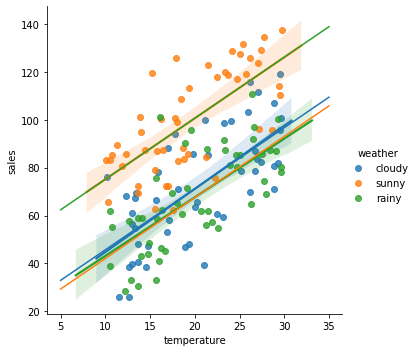

In [46]:
sns.lmplot(x="temperature",y="sales",data=sales_climate,hue="weather")
x = np.linspace(5,35,100)
y = lambda x :b3*x+b0
y1 = lambda x : b3*x+b1+b0
y2 = lambda x : b3*x+b2+b0
plt.plot(x,y(x))
plt.plot(x,y1(x))
plt.plot(x,y2(x))

In [11]:
d = pd.read_csv("input/data-attendance-1.txt")
d.head()

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


In [12]:
data = d.copy()
data = data.sort_values(by='A').reset_index().drop('index',axis=1)
data['Score'] = data['Score']/200
data.describe()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,A,Score,Y
count,50.000000,50.000000,50.00000
mean,0.400000,0.608500,0.26354
std,0.494872,0.140684,0.09747
min,0.000000,0.255000,0.02700
25%,0.000000,0.526250,0.19525
50%,0.000000,0.602500,0.27000
75%,1.000000,0.712500,0.34300
max,1.000000,0.925000,0.42300


In [13]:
N = len(data)
K = 3
Y = data['Y']
col = data.columns
X = pd.DataFrame({'intercept':1,
                  col[0]:data[col[0]],
                  col[1]:data[col[1]]})

data = dict(N=N,K=K,Y=Y,X=X)
data

{'K': 3, 'N': 50, 'X':     intercept  A  Score
 0           1  0  0.345
 1           1  0  0.565
 2           1  0  0.805
 3           1  0  0.595
 4           1  0  0.595
 5           1  0  0.655
 6           1  0  0.495
 7           1  0  0.550
 8           1  0  0.445
 9           1  0  0.440
 10          1  0  0.645
 11          1  0  0.925
 12          1  0  0.410
 13          1  0  0.570
 14          1  0  0.630
 15          1  0  0.665
 16          1  0  0.555
 17          1  0  0.610
 18          1  0  0.685
 19          1  0  0.740
 20          1  0  0.725
 21          1  0  0.730
 22          1  0  0.910
 23          1  0  0.555
 24          1  0  0.665
 25          1  0  0.525
 26          1  0  0.255
 27          1  0  0.625
 28          1  0  0.750
 29          1  0  0.545
 30          1  1  0.525
 31          1  1  0.620
 32          1  1  0.585
 33          1  1  0.370
 34          1  1  0.725
 35          1  1  0.430
 36          1  1  0.790
 37          1  1  0.735
 38

In [14]:
fit_nuts = stanmodel.sampling(data=data,n_jobs=-1)
fit_nuts

Inference for Stan model: anon_model_f80452aa85a6818d76645a3918d461a8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]    0.12  8.5e-4   0.03   0.06    0.1   0.12   0.15   0.19   1544    1.0
b[2]   -0.14  2.7e-4   0.01  -0.17  -0.15  -0.14  -0.13  -0.11   2982    1.0
b[3]    0.33  1.4e-3   0.05   0.22   0.29   0.32   0.36   0.43   1563    1.0
sigma   0.05  1.1e-4 5.5e-3   0.04   0.05   0.05   0.06   0.06   2589    1.0
lp__  120.86    0.04   1.44 117.28 120.15 121.22 121.93 122.66   1369    1.0

Samples were drawn using NUTS at Mon Dec  2 06:33:10 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [0]:
def pairplot(df, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.figure import figaspect
    import seaborn as sns

    def corrplot(x, y, data, cmap=None, correlation='pearson', **kwargs):
        from scipy import stats
        from matplotlib.patches import Ellipse

        if correlation is 'spearman':
            r = stats.spearmanr(data[x], data[y])[0]
        else:
            r = stats.pearsonr(data[x], data[y])[0]
        if cmap is None:
            cmap = 'coolwarm'
        if type(cmap) is str:
            cmap = plt.get_cmap(cmap)
        color = cmap((r+1)/2)
        ax.axis('off')
        ax.add_artist(Ellipse((0.5, 0.5), width=np.sqrt(1+r), height=np.sqrt(1-r), angle=45, color=color))
        ax.text(0.5, 0.5, '{:.2f}'.format(r), size='x-large', horizontalalignment='center', verticalalignment='center')

    def crosstabplot(x, y, data, ax, **kwargs):
        import pandas as pd

        cross = pd.crosstab(data[x], data[y]).values
        size = cross / cross.max() * 500
        crosstab_kws = kwargs['crosstab_kws'] if 'crosstab_kws' in kwargs else {}
        scatter_kws = dict(color=sns.color_palette()[0], alpha=0.3)
        scatter_kws.update(crosstab_kws['scatter_kws'] if 'scatter_kws' in crosstab_kws else {})
        text_kws = dict(size='x-large')
        text_kws.update(crosstab_kws['text_kws'] if 'text_kws' in crosstab_kws else {})
        for (xx, yy), count in np.ndenumerate(cross):
            ax.scatter(xx, yy, s=size[xx, yy], **scatter_kws)
            ax.text(xx, yy, count, horizontalalignment='center', verticalalignment='center', **text_kws)

    def catplot(x, y, hue, data, orient, ax, **kwargs):
        box_kws = dict(color='w')
        box_kws.update(kwargs['box_kws'] if 'box_kws' in kwargs else {})
        sns.boxplot(x, y, data=data, orient=orient, ax=ax, **box_kws)
        strip_kws = dict(color=None if hue else sns.color_palette()[0])
        strip_kws.update(kwargs['strip_kws'] if 'strip_kws' in kwargs else {})
        sns.stripplot(x, y, hue, data, orient=orient, ax=ax, **strip_kws)
        legend = ax.get_legend()
        if legend:
            plt.setp(legend, visible=False)

    def scatterplot(x, y, hue, data, ax, **kwargs):
        if hue:
            hues = data[hue].unique()
            colors = sns.color_palette(n_colors=hues.size)
            for h, c in zip(hues, colors):
                ax.scatter(x, y, data=data.query('{col}=={value}'.format(col=hue, value=h)), color=c, **kwargs)
        else:
            ax.scatter(x, y, data=data, **kwargs)

    n_variables = df.columns.size
    hue = kwargs['hue'] if 'hue' in kwargs else None
    figsize = kwargs['figsize'] if 'figsize' in kwargs else figaspect(1) * 0.5 * n_variables
    _, axes = plt.subplots(n_variables, n_variables, figsize=figsize)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(n_variables):
        axes[i, i].get_shared_x_axes().join(*axes[i:n_variables, i])
        if i > 1:
            axes[i, 0].get_shared_y_axes().join(*axes[i, :i-1])

    for (row, col), ax in np.ndenumerate(axes):
        x = df.columns[col]
        y = df.columns[row]
        x_data = df[x]
        y_data = df[y]
        x_dtype = x_data.dtype.name
        y_dtype = y_data.dtype.name
        if x_dtype == 'category':
            x_categories = x_data.cat.categories
        if y_dtype == 'category':
            y_categories = y_data.cat.categories

        if row == col: # diagonal
            hue_data = df[hue] if hue else None
            if x_dtype == 'category':
                bar_kws = dict(alpha=0.4)
                bar_kws.update(kwargs['bar_kws'] if 'bar_kws' in kwargs else {})
                if hue:
                    cross = pd.crosstab(x_data, hue_data)
                    cross.index = cross.index.categories
                    cross.columns = cross.columns.categories if hue_data.dtype.name == 'category' else hue_data.unique()
                    cross.reset_index(inplace=True)
                    melt = pd.melt(cross, id_vars='index',var_name='hue')
                    sns.barplot('index', 'value', 'hue', data=melt, ci=None, orient='v', dodge=False, ax=ax, **bar_kws)
                    plt.setp(ax.get_legend(), visible=False)
                else:
                    cross = pd.crosstab(x_data, []).values.ravel()
                    sns.barplot(x_data.cat.categories, cross, ci=None, orient='v', color=sns.color_palette()[0], ax=ax, **bar_kws)
            else:
                dist_kws = kwargs['dist_kws'] if 'dist_kws' in kwargs else {}
                if hue:
                    hist_kws = dict(color=sns.color_palette(n_colors=hue_data.unique().size), alpha=0.4)
                    hist_kws.update(dist_kws['hist_kws'] if 'hist_kws' in dist_kws else {})
                    hue_values = df[hue].cat.categories if hue_data.dtype.name == 'category' else df[hue].unique()
                    ax.hist([df.query('{hue}=={v}'.format(hue=hue, v=v))[x] for v in hue_values], density=True, histtype='barstacked', **hist_kws)
                    sns.distplot(x_data, hist=False, ax=ax, **dist_kws)
                else:
                    sns.distplot(x_data, ax=ax, **dist_kws)
        elif row < col: # upper
            corr_kws = kwargs['corr_kws'] if 'corr_kws' in kwargs else {}
            corrplot(x, y, data=df, **corr_kws)
        else: # lower
            if x_dtype == 'category' and y_dtype == 'category':
                crosstabplot(x, y, data=df, ax=ax)
            else:
                cat_kws = kwargs['cat_kws'] if 'cat_kws' in kwargs else {}
                if x_dtype == 'category':
                    catplot(x, y, hue, df, 'v', ax, **cat_kws)
                elif y_dtype == 'category':
                    catplot(x, y, hue, df, 'h', ax, **cat_kws)
                else:
                    scatter_kws = kwargs['scatter_kws'] if 'scatter_kws' in kwargs else {}
                    scatterplot(x, y, hue, df, ax, **scatter_kws)
        if row < n_variables-1:
            plt.setp(ax, xlabel='')
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            plt.setp(ax, xlabel=x)
            if x_dtype == 'category':
                plt.setp(ax, xticks=np.arange(x_categories.size), xticklabels=x_data.cat.categories)
        if col > 0:
            plt.setp(ax, ylabel='')
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            plt.setp(ax, ylabel=y)
            if row > 0 and y_dtype == 'category':
                plt.setp(ax, yticks=np.arange(y_categories.size), yticklabels=y_data.cat.categories)

    return axes